# FlowEdit

FlowEdit: Inversion-Free Text-Based Editing Using Pre-Trained Flow Models, Kulikov et al., 2024. [[arXiv:2412.08629](https://arxiv.org/pdf/2412.08629)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

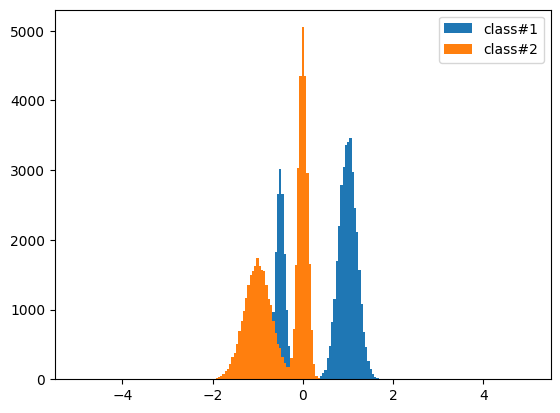

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D


mixture_1 = D.MixtureSameFamily(
    D.Categorical(torch.tensor([0.3, 0.7])),
    D.Normal(torch.tensor([-0.5, 1.0]), torch.tensor([0.1, 0.2])),
)
mixture_2 = D.MixtureSameFamily(
    D.Categorical(torch.tensor([0.5, 0.5])),
    D.Normal(torch.tensor([0.0, -1.0]), torch.tensor([0.1, 0.3])),
)
# target distribution
X_1 = mixture_1.sample((50000, 1))
X_2 = mixture_2.sample((50000, 1))

plt.hist(X_1.view(-1), bins=np.linspace(-5, 5, 200), label="class#1")
plt.hist(X_2.view(-1), bins=np.linspace(-5, 5, 200), label="class#2")
plt.legend()

## 2. Define Model

Define MLP backbone and scaled consistency training framework.

In [2]:
from typing import Callable, Iterable

import torch
import torch.nn as nn

from flowmodels import RectifiedFlow
from flowmodels.flowedit import ConditionalVelocitySupports


class ConditionalRF(RectifiedFlow, ConditionalVelocitySupports):
    def velocity(
        self, x_t: torch.Tensor, t: torch.Tensor, c: torch.Tensor | None = None
    ) -> torch.Tensor:
        return self.velocity_estim.forward(x_t, t, c)

    def loss(
        self,
        sample: torch.Tensor,
        t: torch.Tensor | None = None,
        src: torch.Tensor | None = None,
        c: torch.Tensor | None = None,
    ) -> torch.Tensor:
        # B
        batch_size, *_ = sample.shape
        # sample
        t = torch.rand(batch_size)
        src = torch.randn_like(sample)
        # compute objective
        backup = t
        # [B, ...]
        t = t.view([batch_size] + [1] * (sample.dim() - 1))
        # [B, ...]
        estim = self.velocity(t * sample + (1 - t) * src, backup, c)
        return ((sample - src) - estim).square().mean()

    def sample(
        self,
        prior: torch.Tensor,
        steps: int | None = 1,
        verbose: Callable[[range], Iterable] | None = None,
        c: torch.Tensor | None = None,
    ) -> tuple[torch.Tensor, list[torch.Tensor]]:
        # assign default values
        steps = steps or 10
        if verbose is None:
            verbose = lambda x: x
        # loop
        x_t, x_ts = prior, []
        bsize, *_ = x_t.shape
        with torch.inference_mode():
            for i in verbose(range(steps)):
                velocity = self.velocity(
                    x_t,
                    torch.full((bsize,), i / steps, dtype=torch.float32),
                    c,
                )
                x_t = x_t + velocity / steps
                x_ts.append(x_t)
        return x_t, x_ts


class Backbone(nn.Module):
    def __init__(self, dim: int = 1, layers: int = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 2, 64),
            *[
                submodule
                for _ in range(layers)
                for submodule in (nn.ReLU(), nn.Linear(64, 64))
            ],
            nn.ReLU(),
            nn.Linear(64, dim),
        )

    def forward(
        self,
        x_t: torch.Tensor,
        t: torch.Tensor,
        c: torch.Tensor | None = None,
    ) -> torch.Tensor:
        if c is not None:
            x_t = torch.cat([x_t, c[:, None].to(x_t)], dim=-1)
        x_t = torch.cat([x_t, t[:, None].to(x_t)], dim=-1)
        return self.net.forward(x_t)


model = ConditionalRF(Backbone())
model

ConditionalRF(
  (velocity_estim): Backbone(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train Conditional Rectified Flows

Train the conditional rectified flows with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

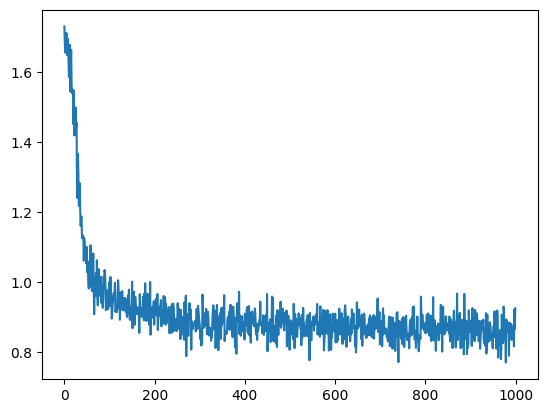

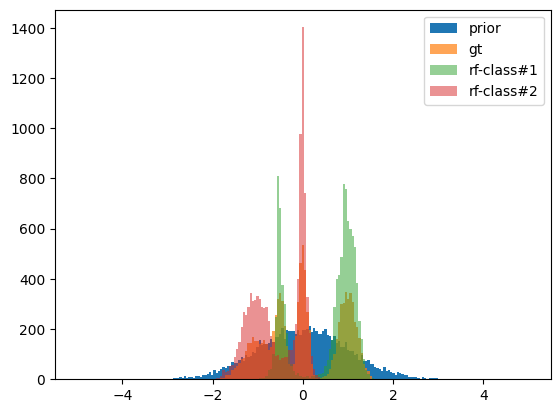

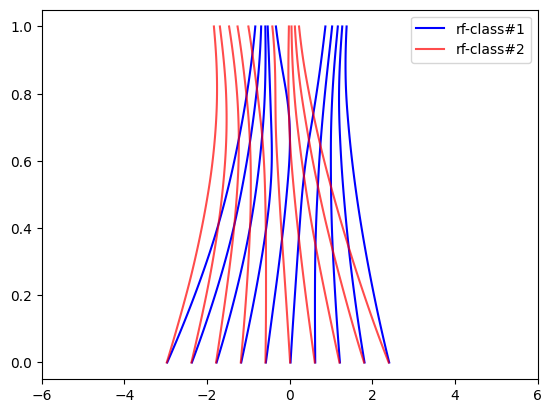

In [3]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

X = torch.cat(
    [
        F.pad(X_1, [0, 1], "constant", 1.0),
        F.pad(X_2, [0, 1], "constant", 2.0),
    ],
    dim=0,
)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        x = X[torch.randint(0, len(X), (BATCH_SIZE,))]
        loss = model.loss(x[..., :-1], c=x[..., -1])
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)

# plot histogram
n = 10000
sample = torch.randn(n, 1)
with torch.inference_mode():
    x_1, _ = model.sample(
        sample,
        steps=100,
        c=torch.ones(n),
        verbose=lambda x: tqdm(x, leave=False),
    )
    x_2, _ = model.sample(
        sample,
        steps=100,
        c=torch.ones(n) * 2.0,
        verbose=lambda x: tqdm(x, leave=False),
    )

plt.figure()
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(
    torch.cat([X_1[: n // 2], X_2[: n // 2]], dim=0),
    bins=np.linspace(-5, 5, 200),
    label="gt",
    alpha=0.7,
)
plt.hist(x_1.view(-1), bins=np.linspace(-5, 5, 200), label="rf-class#1", alpha=0.5)
plt.hist(x_2.view(-1), bins=np.linspace(-5, 5, 200), label="rf-class#2", alpha=0.5)
# plt.hist(x_2.view(-1), bins=np.linspace(-5, 5, 200), label="sct-2", alpha=0.5)
plt.legend()
_xticks, _ = plt.xticks()

# plot trajectory
n = 200
with torch.inference_mode():
    _, x_1s = model.sample(
        torch.linspace(-3, 3, n)[:, None], steps=100, c=torch.ones(n)
    )
    _, x_2s = model.sample(
        torch.linspace(-3, 3, n)[:, None], steps=100, c=torch.ones(n) * 2.0
    )

plt.figure()
for i in range(10):
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_1s]),
        np.linspace(0, 1, len(x_1s)),
        "b",
        **({} if i > 0 else {"label": "rf-class#1"}),  # labeling on first plot only
    )
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_2s]),
        np.linspace(0, 1, len(x_2s)),
        "r",
        alpha=0.7,
        **({} if i > 0 else {"label": "rf-class#2"}),  # labeling on first plot only
    )
    plt.xticks(_xticks)
plt.legend()

## 4. Run FlowEdit

Transfer the sample from class#1 to class#2

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

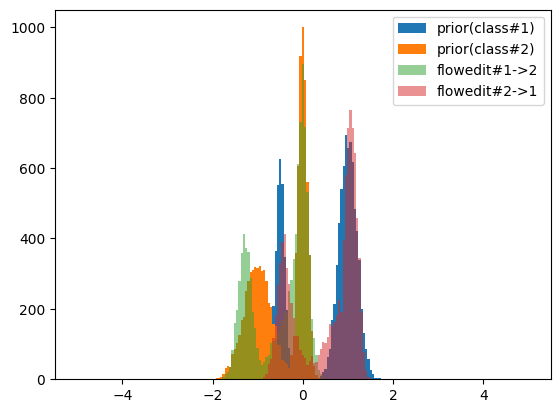

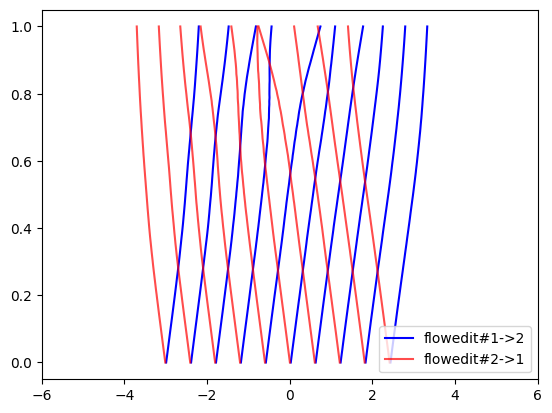

In [4]:
from flowmodels import FlowEditSolver

transport = FlowEditSolver()
with torch.inference_mode():
    x_1, _ = transport.solve(
        model,
        X_2,
        steps=100,
        verbose=lambda x: tqdm(x, leave=False),
        src=torch.ones(len(X_1)) * 2,
        tgt=torch.ones(len(X_1)),
        n_avg=10,
    )
    x_2, _ = transport.solve(
        model,
        X_1,
        steps=100,
        verbose=lambda x: tqdm(x, leave=False),
        src=torch.ones(len(X_1)),
        tgt=torch.ones(len(X_1)) * 2,
        n_avg=10,
    )

# plot histogram
n = 10000
plt.figure()
plt.hist(X_1[:n], bins=np.linspace(-5, 5, 200), label="prior(class#1)")
plt.hist(X_2[:n], bins=np.linspace(-5, 5, 200), label="prior(class#2)")
plt.hist(
    x_2[:n].view(-1), bins=np.linspace(-5, 5, 200), label="flowedit#1->2", alpha=0.5
)
plt.hist(
    x_1[:n].view(-1), bins=np.linspace(-5, 5, 200), label="flowedit#2->1", alpha=0.5
)
plt.legend()
_xticks, _ = plt.xticks()

# plot trajectory
n = 200
with torch.inference_mode():
    _, x_1s = transport.solve(
        model,
        torch.linspace(-3, 3, n)[:, None],
        steps=100,
        verbose=lambda x: tqdm(x, leave=False),
        src=torch.ones(n) * 2,
        tgt=torch.ones(n),
        n_avg=10,
    )
    _, x_2s = transport.solve(
        model,
        torch.linspace(-3, 3, n)[:, None],
        steps=100,
        verbose=lambda x: tqdm(x, leave=False),
        src=torch.ones(n),
        tgt=torch.ones(n) * 2,
        n_avg=10,
    )

plt.figure()
for i in range(10):
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_1s]),
        np.linspace(0, 1, len(x_2s)),
        "b",
        **({} if i > 0 else {"label": "flowedit#1->2"}),  # labeling on first plot only
    )
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_2s]),
        np.linspace(0, 1, len(x_1s)),
        "r",
        alpha=0.7,
        **({} if i > 0 else {"label": "flowedit#2->1"}),  # labeling on first plot only
    )
    plt.xticks(_xticks)
plt.legend()